In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mytrainingdata = pd.read_csv('train_data_augmented.csv',index_col=0) #set date as index
mytestdata = pd.read_csv('test_data_augmented.csv',index_col=0) #set date as index

X_train = mytrainingdata.drop(['Max_Demand_GW','Plant_Production_GWh'],axis = 1)
y_train = mytrainingdata['Max_Demand_GW']
X_test = mytestdata.drop(['Max_Demand_GW','Plant_Production_GWh'],axis = 1)
y_test = mytestdata['Max_Demand_GW']

In [2]:
#NOT DROPPING Plant_Production_GWh

X_train = mytrainingdata.drop(['Max_Demand_GW'],axis = 1)
y_train = mytrainingdata['Max_Demand_GW']
X_test = mytestdata.drop(['Max_Demand_GW'],axis = 1)
y_test = mytestdata['Max_Demand_GW']

In [3]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor

#Instantiate the model
model = RandomForestRegressor(n_estimators = 30,random_state = 30)
#n_estimators = number of trees
#random_state = random seed for reproducibility

#Fitting the rf model to the training data
fitted_rf = model.fit(X_train, y_train)

y_pred = fitted_rf.predict(X_test)

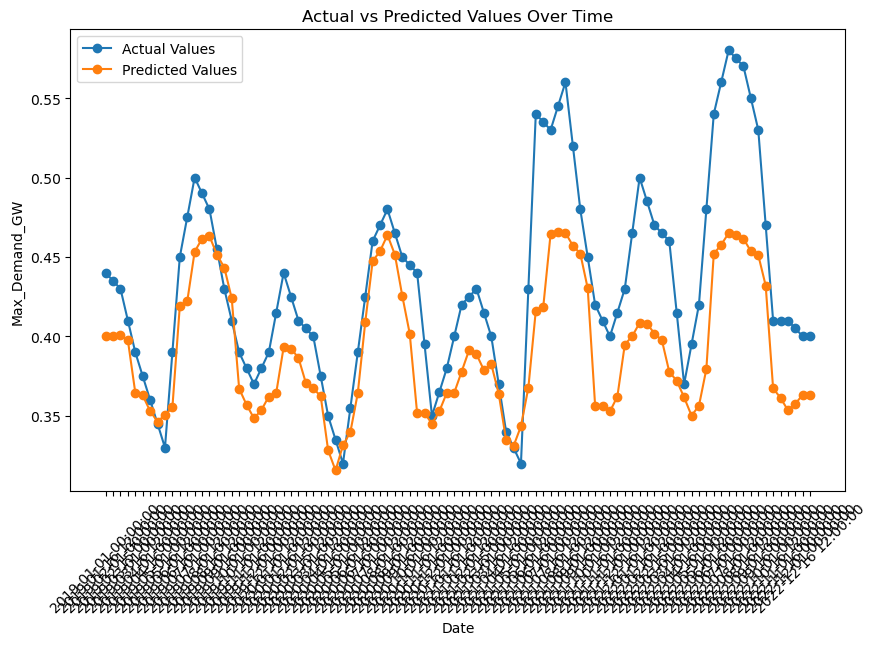

In [4]:
import matplotlib.pyplot as plt

# Plotting y_test and y_pred against date
plt.figure(figsize=(10, 6))

# Plotting y_test
plt.plot(y_test.index, y_test, label='Actual Values', marker='o')

# Plotting y_pred
plt.plot(y_test.index, y_pred, label='Predicted Values', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Max_Demand_GW')
plt.title('Actual vs Predicted Values Over Time')

# Adding a legend
plt.legend()

# Rotating x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [5]:
f_list = list(X_train.columns)
f_importance = pd.Series(model.feature_importances_,index = f_list).sort_values(ascending = False)
print(f_importance)

Plant_Production_GWh         0.638600
tavg                         0.193558
tmax                         0.045663
tmin                         0.039403
Population_k                 0.037525
GDP_mln                      0.024608
powerplants_c02_kt           0.014405
Imports_GWh                  0.005821
Renewables_Production_GWh    0.000417
dtype: float64


Cross-validation and hyperparameter tuning are related concepts but refer to different aspects of the machine learning model development process.

1. **Cross-Validation:**
   - Cross-validation is a technique used to assess how well a machine learning model generalizes to an independent dataset. It involves splitting the dataset into multiple subsets (folds), training the model on several combinations of training and validation sets, and then evaluating its performance on the held-out validation sets. Common cross-validation methods include k-fold cross-validation, stratified k-fold cross-validation, and leave-one-out cross-validation.
   - The primary goal of cross-validation is to provide a more robust estimate of the model's performance by evaluating it on multiple subsets of the data.

2. **Hyperparameter Tuning:**
   - Hyperparameter tuning involves finding the optimal values for hyperparameters, which are external configuration settings of a machine learning model. Examples of hyperparameters include the learning rate, the number of trees in a random forest, or the depth of a decision tree. The choice of hyperparameters can significantly impact the model's performance.
   - Techniques for hyperparameter tuning include grid search, randomized search, and more advanced methods such as Bayesian optimization. Hyperparameter tuning aims to find the set of hyperparameter values that results in the best model performance.

While these concepts are distinct, they are often used together in the model development process:

- Cross-validation helps assess how well a model generalizes across different subsets of the data.
- Hyperparameter tuning helps identify the optimal hyperparameter values that maximize the model's performance.

In summary, cross-validation is a technique for model evaluation, and hyperparameter tuning is a process of finding the best configuration for a model by optimizing hyperparameters. They complement each other in the overall effort to build a robust and well-performing machine learning model.

max_depth:
max_depth controls the maximum depth of the decision tree. A deeper tree can capture more complex relationships in the training data, but it also increases the risk of overfitting.
For small datasets or datasets with simple patterns, a lower max_depth might be sufficient to avoid overfitting.
For larger datasets or datasets with complex patterns, you might experiment with higher values for max_depth.
min_samples_split:
min_samples_split sets the minimum number of samples required to split an internal node. It helps control the granularity of splits in the tree.
A higher min_samples_split generally results in a more generalized tree by preventing the model from creating splits for small subsets of the data.
Smaller values might be appropriate if the data is noisy or contains many fine-grained patterns.

# Cross Validation

In [11]:
from numpy import absolute

#The k-fold CV
from sklearn.model_selection import cross_val_score

seed = 7

#Training model CV
score_train = cross_val_score(fitted_rf,X_train,y_train,scoring='neg_mean_squared_error',cv = 10)

print(score_train)

#The absolute mean score
print(absolute(np.mean(score_train)))

#The testing model CV
score_test = cross_val_score(fitted_rf,X_test,y_test,scoring='neg_mean_squared_error',cv=10)

print(score_test)
print(absolute(np.mean(score_test)))

[-0.00023479 -0.00024505 -0.00024066 -0.00050318 -0.00013962 -0.00017888
 -0.00017964 -0.00033445 -0.00031523 -0.00154893]
0.0003920445381616434
[-0.00048699 -0.00078211 -0.00018573 -0.00152594 -0.00024436 -0.00232838
 -0.00042524 -0.00185519 -0.00096803 -0.00097101]
0.0009772980246913567


# Hyperparameter Tuning

In [8]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [5, 10, 30, 50, 100, 150, 200],
    'max_depth': [None, 2, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7] 
}

# Create the Random Forest regressor
rf = RandomForestRegressor(random_state=30)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred_best = best_model.predict(X_test)


Best Hyperparameters: {'max_depth': None, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


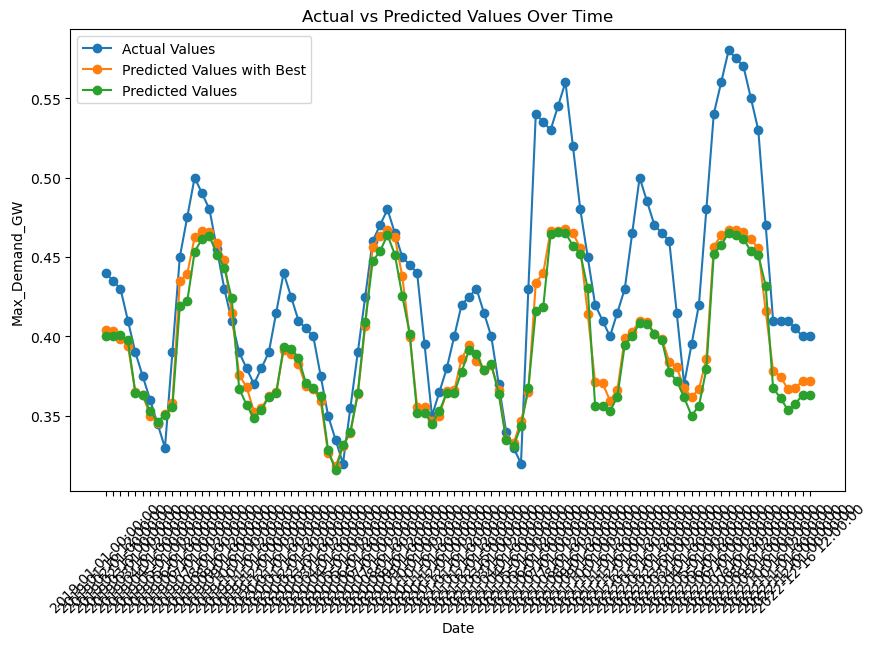

In [9]:
import matplotlib.pyplot as plt

# Plotting y_test and y_pred against date
plt.figure(figsize=(10, 6))

# Plotting y_test
plt.plot(y_test.index, y_test, label='Actual Values', marker='o')

# Plotting y_pred
plt.plot(y_test.index, y_pred_best, label='Predicted Values with Best', marker='o')

plt.plot(y_test.index, y_pred, label='Predicted Values', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Max_Demand_GW')
plt.title('Actual vs Predicted Values Over Time')

# Adding a legend
plt.legend()

# Rotating x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [10]:
#EVALUATE


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)

#Taking the square root of Mean Squared Error (MSE) gives you the Root Mean Squared Error (RMSE). The primary reason to use RMSE instead of MSE is that it has the same scale as the original target variable, making it more interpretable and easier to relate to the actual values of the variable.

# Calculate Explained Variance Score
explained_variance = explained_variance_score(y_test, y_pred)




# Calculate R-squared
r2b = r2_score(y_test, y_pred_best)

# Calculate Mean Absolute Error
maeb = mean_absolute_error(y_test, y_pred_best)

# Calculate Mean Squared Error
mseb = mean_squared_error(y_test, y_pred_best)

# Calculate Root Mean Squared Error
rmseb = np.sqrt(mse)

#Taking the square root of Mean Squared Error (MSE) gives you the Root Mean Squared Error (RMSE). The primary reason to use RMSE instead of MSE is that it has the same scale as the original target variable, making it more interpretable and easier to relate to the actual values of the variable.

# Calculate Explained Variance Score
explained_varianceb = explained_variance_score(y_test, y_pred_best)



# Display the results
print(f'R-squared: {r2:.4f} (Ideal: 1)')
print(f'New R-squared: {r2b:.4f} (Ideal: 1) \n')
print(f'Mean Absolute Error: {mae:.4f} (Ideal: 0)')
print(f'New Mean Absolute Error: {maeb:.4f} (Ideal: 0) \n')
print(f'Mean Squared Error: {mse:.4f} (Ideal: 0)')
print(f'New Mean Squared Error: {mseb:.4f} (Ideal: 0) \n')
print(f'Root Mean Squared Error: {rmse:.4f} (Ideal: 0)')
print(f'New Root Mean Squared Error: {rmseb:.4f} (Ideal: 0) \n')
print(f'Explained Variance Score: {explained_variance:.4f} (Ideal: 1)')
print(f'New Explained Variance Score: {explained_varianceb:.4f} (Ideal: 1)')

R-squared: 0.3056 (Ideal: 1)
New R-squared: 0.4019 (Ideal: 1) 

Mean Absolute Error: 0.0421 (Ideal: 0)
New Mean Absolute Error: 0.0386 (Ideal: 0) 

Mean Squared Error: 0.0027 (Ideal: 0)
New Mean Squared Error: 0.0023 (Ideal: 0) 

Root Mean Squared Error: 0.0517 (Ideal: 0)
New Root Mean Squared Error: 0.0517 (Ideal: 0) 

Explained Variance Score: 0.7276 (Ideal: 1)
New Explained Variance Score: 0.7518 (Ideal: 1)


In [ ]:
COMMENT ON DIFFERENCE IN BEST CONDITIONS WHEN USING AUGMENTED DATASET VS ORIGINAL DATASET

In [ ]:
CONSIDER OTHER CONDITIONS